 ### Spark Machine Learning Pipeline:
 -  ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines.

####  Main concepts in pipeline
  - MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow.
  - Mostly inspired by the **scikit-learn** project.
  - Dataframe
    - This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.
    - vectors, text, images, and structured data
    - Created either implicitly or explicitly from a regular RDD.
  - Transformer
     - A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
  - Estimator
    - An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
  - Pipeline
    - A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow. 
  - parameter
     - All Transformers and Estimators now share a common API for specifying parameters.


#### Components of pipeline:
- Transformer
   - An abstraction that includes feature transformers and learned models. 
   - Implements a method transform()
   - Converts one DataFrame into another, generally by appending one or more columns. 
   - A feature transformer might take a DataFrame, read a column (e.g., text), map it into a new column (e.g., feature vectors), and output a new DataFrame with the mapped column appended.
   - A learning model might take a DataFrame, read the column containing feature vectors, predict the label for each feature vector, and output a new DataFrame with predicted labels appended as a column
- Estimator
   - Concept of a learning algorithm or any algorithm that fits or trains on data. 
   - Implements a method fit()
   - Accepts a DataFrame and produces a Model, which is a Transformer.
   - A learning algorithm such as LogisticRegression is an Estimator, and calling fit() trains a LogisticRegressionModel, which is a Model and hence a Transformer.

#### Properties of components
- Transformer.transform()s and Estimator.fit()s are both stateless. In the future, stateful algorithms may be supported via alternative concepts.
- Each instance of a Transformer or Estimator has a unique ID, which is useful in specifying parameters.

#### Pipeline:
- In machine learning, it is common to run a sequence of algorithms to process and learn from data.
- E.g., a simple text document processing workflow might include several stages:
    - Split each document’s text into words.
    - Convert each document’s words into a numerical feature vector.
    - Learn a prediction model using the feature vectors and labels.
- This process of workflow is called pipeline   
- A sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. 

#### Parameters:
- A Param is a named parameter with self-contained documentation. A ParamMap is a set of (parameter, value) pairs.
- Set parameters for an instance. E.g., if lr is an instance of LogisticRegression, one could call lr.setMaxIter(10) to make lr.fit() use at most 10 iterations. This API resembles the API used in spark.mllib package.
- Pass a ParamMap to fit() or transform(). Any parameters in the ParamMap will override parameters previously specified via setter methods.
- Parameters belong to specific instances of Estimators and Transformers. 

#### How does it work?
- A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator. 
- These stages are run in order, and the input DataFrame is transformed as it passes through each stage. 
- For Transformer stages, the transform() method is called on the DataFrame. 
- For Estimator stages, the fit() method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s transform() method is called on the DataFrame.
- Pipelines and PipelineModels help to ensure that training and test data go through identical feature processing steps.
- 

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext,SparkConf
import time,os
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [2]:
# Create Spark Session
conf=SparkConf()
sc=SparkContext(conf=conf)

# Stop default sc
sc.stop()
spark = SparkSession \
    .builder \
    .master("spark://Kirtis-MacBook-Pro.local:7077") \
    .appName("Spark_Machine_learning") \
    .config("spark.executor.memory",'2g') \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/01 10:31:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
## Verify that we are accessing the data file
data_folder = "/Users/Kirtikamerkar/Austincapitaldata/data"
data_path=data_folder+"/influenza-surveillance-jtpkmr/influenza.csv"
print(f"The file at `{data_path}` {'exists' if os.path.isfile(data_path) else 'does NOT exist! Check your path'}.")

The file at `/Users/Kirtikamerkar/Austincapitaldata/data/influenza-surveillance-jtpkmr/influenza.csv` exists.


In [5]:
#Loading influenza data
influenza_df=spark.read.csv(data_path,inferSchema = True,header=True)

In [6]:
influenza_df.show()

+---------+---------+----------+--------------+-----------------+---------------+----------------+----------------+
|   season|date_code|weekending|        region|Respiratory_Virus|Number_Positive|Specimens_Tested|Percent_Positive|
+---------+---------+----------+--------------+-----------------+---------------+----------------+----------------+
|2009-2010|   200940|  10/10/09|      Bay Area|      Influenza_A|             36|             220|           16.36|
|2009-2010|   200940|  10/10/09|      Bay Area|      Influenza_B|              0|             220|             0.0|
|2009-2010|   200940|  10/10/09|      Bay Area|  Total_Influenza|             36|             220|           16.36|
|2009-2010|   200940|  10/10/09|      Bay Area|              RSV|              0|             190|             0.0|
|2009-2010|   200940|  10/10/09|    California|      Influenza_A|           1077|            3324|            32.4|
|2009-2010|   200940|  10/10/09|    California|      Influenza_B|       

In [6]:
influenza_df.columns

['season',
 'date_code',
 'weekending',
 'region',
 'Respiratory_Virus',
 'Number_Positive',
 'Specimens_Tested',
 'Percent_Positive']

In [7]:
influenza_df.toPandas().describe()

,date_code,Number_Positive,Specimens_Tested,Percent_Positive
count,50011.000000,50011.000000,50011.000000,42414.000000
mean,201658.047570,20.653936,351.877027,3.943707
std,263.947403,91.746507,611.778964,7.121999
min,200940.000000,0.000000,0.000000,0.000000
25%,201507.000000,0.000000,40.000000,0.000000
50%,201707.000000,1.000000,133.000000,0.710000
75%,201849.000000,7.000000,402.000000,4.550000
max,202039.000000,3120.000000,8013.000000,100.000000


In [8]:
influenza_df.printSchema()

root
 |-- season: string (nullable = true)
 |-- date_code: integer (nullable = true)
 |-- weekending: string (nullable = true)
 |-- region: string (nullable = true)
 |-- Respiratory_Virus: string (nullable = true)
 |-- Number_Positive: integer (nullable = true)
 |-- Specimens_Tested: integer (nullable = true)
 |-- Percent_Positive: double (nullable = true)



In [9]:
#Renaming Column names
from pyspark.sql.functions import *
influenza_df=influenza_df.withColumnRenamed("season","Season").withColumnRenamed("date_code","Date_Code").withColumnRenamed('weekending',"Weekending").withColumnRenamed("region","Region").withColumn('Respiratory_Virus',col('Respiratory_Virus')).withColumn("Number_Positive",col("Number_Positive")).withColumn("Specimens_Tested",col("Specimens_Tested")).withColumn("Percent_Positive",col("Percent_Positive"))

In [10]:
influenza_df.show(5)

+---------+---------+----------+----------+-----------------+---------------+----------------+----------------+
|   Season|Date_Code|Weekending|    Region|Respiratory_Virus|Number_Positive|Specimens_Tested|Percent_Positive|
+---------+---------+----------+----------+-----------------+---------------+----------------+----------------+
|2009-2010|   200940|  10/10/09|  Bay Area|      Influenza_A|             36|             220|           16.36|
|2009-2010|   200940|  10/10/09|  Bay Area|      Influenza_B|              0|             220|             0.0|
|2009-2010|   200940|  10/10/09|  Bay Area|  Total_Influenza|             36|             220|           16.36|
|2009-2010|   200940|  10/10/09|  Bay Area|              RSV|              0|             190|             0.0|
|2009-2010|   200940|  10/10/09|California|      Influenza_A|           1077|            3324|            32.4|
+---------+---------+----------+----------+-----------------+---------------+----------------+----------

#### Cleaning Data:

In [11]:
#Replacing all Nan values with zero
influenza_df=influenza_df.fillna(0)

In [12]:
#Removing row with row value zero
influenza_df=influenza_df.toPandas().loc[~(influenza_df.toPandas()==0).all(axis=1)]

In [13]:
influenza_df.shape

(50011, 8)

In [14]:
influenza_df.head()

,Season,Date_Code,Weekending,Region,Respiratory_Virus,Number_Positive,Specimens_Tested,Percent_Positive
0,2009-2010,200940,10/10/09,Bay Area,Influenza_A,36,220,16.36
1,2009-2010,200940,10/10/09,Bay Area,Influenza_B,0,220,0.00
2,2009-2010,200940,10/10/09,Bay Area,Total_Influenza,36,220,16.36
3,2009-2010,200940,10/10/09,Bay Area,RSV,0,190,0.00
4,2009-2010,200940,10/10/09,California,Influenza_A,1077,3324,32.40


In [15]:
#stringindex for respiratory_virus
influenza_df=spark.createDataFrame(influenza_df)
from pyspark.ml.feature import StringIndexer
respiratory_virus_indexer = StringIndexer(inputCol="Respiratory_Virus", outputCol="Respiratory_Virus_Index")


In [ ]:
#influenza_df=respiratory_virus_indexer.fit(influenza_df).transform(influenza_df)

In [16]:
feat_cols=["Date_Code","Number_Positive","Specimens_Tested","Percent_Positive"]
#feature_vector=VectorAssembler(inputCols="feat_cols",outputCol="feature")
vectorAssembler = VectorAssembler(inputCols = feat_cols, outputCol = 'features')

In [17]:
from pyspark.ml.classification import LogisticRegression
train, test = influenza_df.randomSplit([0.7, 0.3])

In [18]:
lr = LogisticRegression(labelCol="Respiratory_Virus_Index")

In [19]:
pipeline1=Pipeline(stages = [respiratory_virus_indexer,vectorAssembler,lr])

In [19]:
#model=pipeline1.fit(train)

23/04/05 14:30:21 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [19]:
# Make predictions on test documents and print columns of interest.
#prediction = model.transform(test)

In [20]:
#prediction.show()

+---------+---------+----------+--------------------+-----------------+---------------+----------------+----------------+-----------------------+--------------------+--------------------+--------------------+----------+
|   Season|Date_Code|Weekending|              Region|Respiratory_Virus|Number_Positive|Specimens_Tested|Percent_Positive|Respiratory_Virus_Index|            features|       rawPrediction|         probability|prediction|
+---------+---------+----------+--------------------+-----------------+---------------+----------------+----------------+-----------------------+--------------------+--------------------+--------------------+----------+
|2009-2010|   200940|  10/10/09|            Bay Area|      Influenza_A|             36|             220|           16.36|                    0.0|[200940.0,36.0,22...|[495.757682133905...|[0.99851296676736...|       0.0|
|2009-2010|   200940|  10/10/09|            Bay Area|  Total_Influenza|             36|             220|           16.36

In [21]:
#prediction.select(["Respiratory_Virus_Index","features","rawPrediction","probability","prediction"]).show()

+-----------------------+--------------------+--------------------+--------------------+----------+
|Respiratory_Virus_Index|            features|       rawPrediction|         probability|prediction|
+-----------------------+--------------------+--------------------+--------------------+----------+
|                    0.0|[200940.0,36.0,22...|[495.757682133905...|[0.99851296676736...|       0.0|
|                    3.0|[200940.0,36.0,22...|[201.176727941652...|[5.74825873594529...|       3.0|
|                    2.0|[200940.0,1.0,787...|[288.798882548750...|[1.87963402669167...|       2.0|
|                    3.0|[200940.0,21.0,15...|[198.221575406162...|[7.98131781167883...|       3.0|
|                    0.0|  (5,[0],[200940.0])|[487.084503727576...|[0.99984025401116...|       0.0|
|                    3.0|(5,[0,4],[200940....|[192.503549535324...|[7.35306201063209...|       3.0|
|                    0.0|[200940.0,627.0,1...|[605.208890669872...|[0.97957218283749...|       0.0|


#### ML Tuning: model selection and hyperparameter tuning
- It Describes how to use MLlib’s tooling for tuning ML algorithms and Pipelines.
- Built-in Cross-Validation and other tooling allow users to optimize hyperparameters in algorithms and Pipelines.

#### Model selection(hyperparameter tuning)
- Using data to find the best model or parameters for a given task i.e. called tunning.
- Individual Estimators such as LogisticRegression, or entire Pipelines which include multiple algorithms, featurization, and other steps.
- Model selection tools
  - CrossValidator
  - TrainValidationSplit
- These tools require the following items:
   - Estimator: algorithm or Pipeline to tune
   - Set of ParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over
   - Evaluator: metric to measure how well a fitted Model does on held-out test data
       - a RegressionEvaluator for regression problems, 
       - a BinaryClassificationEvaluator for binary data, 
       - a MulticlassClassificationEvaluator for multiclass problems,
       - a MultilabelClassificationEvaluator for multi-label classifications,
       - a RankingEvaluator for ranking problems

#### Model selection tools workflow:[ml tunning](https://spark.apache.org/docs/latest/ml-tuning.html)
- They split the input data into separate training and test datasets.
- For each (training, test) pair, they iterate through the set of ParamMaps:
   - For each ParamMap, they fit the Estimator using those parameters, get the fitted Model, and evaluate the Model’s performance using the Evaluator.
   - The default metric used to choose the best ParamMap can be overridden by the setMetricName method in each of evaluators.
- They select the Model produced by the best-performing set of parameters.
- Parameter grid: construct with ParamGridBuilder utility.
- By default, sets of parameters of parameter grid evaluated in serial.
- Parameter evaluation can be done in parallel by setting parallelism with a value of 2 or more (a value of 1 will be serial) before running model selection with CrossValidator or TrainValidationSplit. 
- Parallelism  value up to 10 should be sufficient for most clusters.

#### CrossValidation:
- CrossValidatorModel contains the model with the highest average cross-validation metric across folds and uses this model to transform input data. CrossValidatorModel also tracks the metrics for each param map evaluated.
- Splitting the dataset into a set of folds which are used as separate training and test datasets.
- E.g., with k=4 folds, CrossValidator will generate 4(training, test) dataset pairs, each of which uses 3/4 of the data for training and 1/4 for testing. 
- To evaluate a particular ParamMap, CrossValidator computes the average evaluation metric for the 4 Models produced by fitting the Estimator on the 4 different (training, test) dataset pairs.
- After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset.


In [20]:
# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 2 values for lr.regParam,
# this grid will have 2 parameter settings for CrossValidator to choose from.
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 100]) \
    .build()

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
crossval = CrossValidator(estimator=pipeline1,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Respiratory_Virus_Index',predictionCol="prediction"),
                          numFolds=2)

In [22]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

23/05/01 10:40:26 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


#### Prediction Phase
- In Spark, the method transform() is used for the prediction after passing the test data. Test data also must be a feature vector.
- The transform method automatically adds a series of predicted values to our test data.

In [23]:
prediction = cvModel.transform(test)

In [24]:
prediction.show()

+---------+---------+----------+--------------------+-----------------+---------------+----------------+----------------+-----------------------+--------------------+--------------------+--------------------+----------+
|   Season|Date_Code|Weekending|              Region|Respiratory_Virus|Number_Positive|Specimens_Tested|Percent_Positive|Respiratory_Virus_Index|            features|       rawPrediction|         probability|prediction|
+---------+---------+----------+--------------------+-----------------+---------------+----------------+----------------+-----------------------+--------------------+--------------------+--------------------+----------+
|2009-2010|   200940|  10/10/09|            Bay Area|  Total_Influenza|             36|             220|           16.36|                    1.0|[200940.0,36.0,22...|[7.15851683878224...|[0.04111866022696...|       2.0|
|2009-2010|   200940|  10/10/09|          California|      Influenza_A|           1077|            3324|            32.4

In [ ]:
#colum respiratory_virus is flu or not flu(yes/no)-list of rv with flu(y/n)
#flu_index /prediction logisticregression for binaryclassevaluator model

In [30]:
prediction.select(["Respiratory_Virus_Index","features","rawPrediction","probability","prediction"]).show()

+-----------------------+--------------------+--------------------+--------------------+----------+
|Respiratory_Virus_Index|            features|       rawPrediction|         probability|prediction|
+-----------------------+--------------------+--------------------+--------------------+----------+
|                    1.0|[200940.0,36.0,22...|[7.15851683878224...|[0.04111866022696...|       2.0|
|                    3.0|[200940.0,1077.0,...|[80.6617451179464...|[2.14934460783874...|       1.0|
|                    2.0|[200940.0,2.0,221...|[3.38678940563750...|[0.37457740525941...|       0.0|
|                    2.0|[200940.0,0.0,35....|[2.71819978002201...|[0.23671275896524...|       0.0|
|                    0.0|  (4,[0],[200940.0])|[2.70983442416581...|[0.23252302287193...|       0.0|
|                    3.0|[200940.0,627.0,1...|[50.6845554801914...|[1.86257335769626...|       1.0|
|                    2.0|[200940.0,2.0,151...|[3.22232774430199...|[0.38235562347049...|       0.0|


In [34]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_true =prediction.select("Respiratory_Virus_Index")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(19))
cnf_matrix

array([[633,  14, 101,  27,   7, 131,  24,  17,  10,  35,  31,  21,   3,
          5,  12,   3,   2,   3,  79],
       [454, 104, 220,  60,  11,  37,  29,  11,  13,  21, 117,   0,   7,
          3,  14,   2,   0,   4,  81],
       [417,  47, 223,  55,  12,  70,  30,  21,  12,  26, 135,   8,  11,
          6,  17,   6,   0,   6,  98],
       [587,  52, 185,  54,  10,  63,  24,  16,  11,  33,  74,   2,  13,
          4,  16,   3,   1,   3,  91],
       [224,  30,  68,  11,  20,  97,  47,   8,  17,  25,  23,  10,  14,
         10,  38,   2,   0,   2,  88],
       [236,   8,   6,   0,   0, 302,   0,   0,   0,   0,   3,   0,   0,
          0,   0,   0,   0,   1, 181],
       [169,  43, 134,   8,  12,  35, 106,   7,  31,  19,  67,   2,  10,
          9,  30,   6,   0,   4,  49],
       [235,  24,   6,   2,   1, 248,  14,  16,   7,  14,   2,  10,   3,
          5,   3,  10,   4,   3, 143],
       [235,  53,  52,  19,  24,  32,  78,   7,  58,  23,  21,   0,  26,
         14,  60,   1,   0,   3

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.GnBu):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

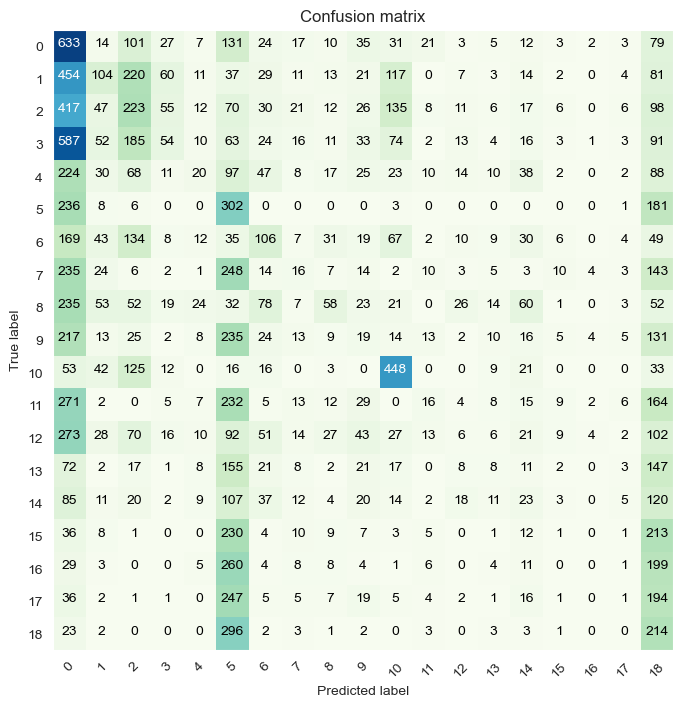

In [40]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(7,7))
plt.grid(False)

# call pre defined function
plot_confusion_matrix(cnf_matrix, classes=range(19))

In [41]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(19)]
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.15      0.55      0.23      1158
     Class 1       0.21      0.09      0.12      1188
     Class 2       0.18      0.19      0.18      1200
     Class 3       0.20      0.04      0.07      1242
     Class 4       0.14      0.03      0.05       734
     Class 5       0.10      0.41      0.17       737
     Class 6       0.20      0.14      0.17       741
     Class 7       0.08      0.02      0.03       750
     Class 8       0.24      0.08      0.12       758
     Class 9       0.05      0.02      0.03       765
    Class 10       0.45      0.58      0.50       778
    Class 11       0.14      0.02      0.03       800
    Class 12       0.05      0.01      0.01       814
    Class 13       0.07      0.02      0.03       503
    Class 14       0.07      0.05      0.05       503
    Class 15       0.02      0.00      0.00       541
    Class 16       0.00      0.00      0.00       543
    Class 17       0.02    

In [42]:
prediction.select("Respiratory_Virus_Index","prediction").show(100)

+-----------------------+----------+
|Respiratory_Virus_Index|prediction|
+-----------------------+----------+
|                    1.0|       2.0|
|                    3.0|       1.0|
|                    2.0|       0.0|
|                    2.0|       0.0|
|                    0.0|       0.0|
|                    3.0|       1.0|
|                    2.0|       0.0|
|                    3.0|       2.0|
|                    0.0|       0.0|
|                    2.0|       0.0|
|                    1.0|       1.0|
|                    3.0|       2.0|
|                    0.0|       0.0|
|                    2.0|       0.0|
|                    1.0|       2.0|
|                    2.0|       0.0|
|                    1.0|       0.0|
|                    3.0|      10.0|
|                    0.0|       0.0|
|                    2.0|       2.0|
|                    2.0|       0.0|
|                    2.0|       0.0|
|                    2.0|       0.0|
|                    0.0|       0.0|
|

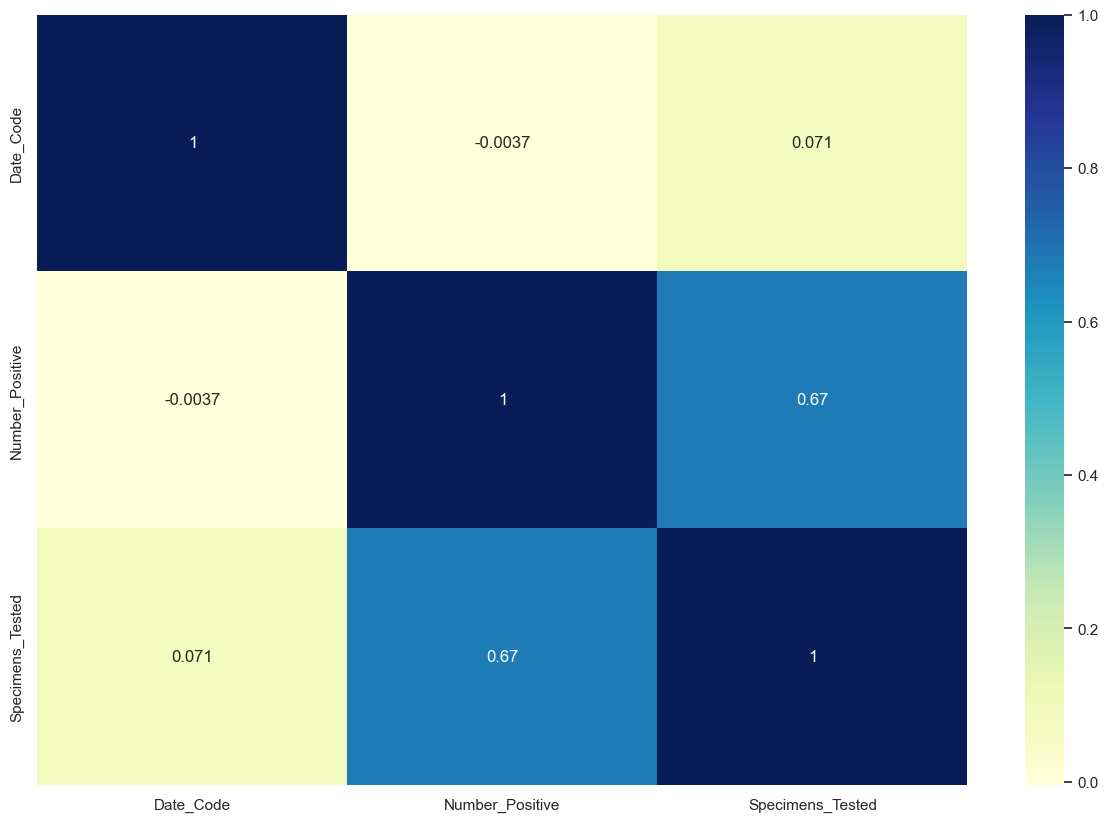

In [43]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(influenza_df.toPandas().iloc[:,:-1].corr(), annot=True, cmap="YlGnBu")
plt.show()

#### Selection of Fine-Tuned Model
- After running the cross validator, cross-validation saves the best fit model and its score.
- bestModel : This method returns the best-fitted model

In [26]:
bestModel = cvModel.bestModel
print(bestModel.stages)

[StringIndexerModel: uid=StringIndexer_3b7aa0b804c9, handleInvalid=error, VectorAssembler_cbf6f5db52de, LogisticRegressionModel: uid=LogisticRegression_b690db5fdb81, numClasses=19, numFeatures=4]


In [27]:
influenza_df.filter(influenza_df.Respiratory_Virus=="Total_Influenza").show()

+---------+---------+----------+--------------------+-----------------+---------------+----------------+----------------+
|   Season|Date_Code|Weekending|              Region|Respiratory_Virus|Number_Positive|Specimens_Tested|Percent_Positive|
+---------+---------+----------+--------------------+-----------------+---------------+----------------+----------------+
|2009-2010|   200940|  10/10/09|            Bay Area|  Total_Influenza|             36|             220|           16.36|
|2009-2010|   200940|  10/10/09|          California|  Total_Influenza|           1080|            3324|           32.49|
|2009-2010|   200940|  10/10/09|             Central|  Total_Influenza|            203|             787|           25.79|
|2009-2010|   200940|  10/10/09|      Lower Southern|  Total_Influenza|             21|             150|            14.0|
|2009-2010|   200940|  10/10/09|            Northern|  Total_Influenza|              0|               0|             0.0|
|2009-2010|   200940|  1

### Train-Validation Split

- TrainValidationSplit only evaluates each combination of parameters once, as opposed to k times in the case of CrossValidator. It is, therefore, less expensive, but will not produce as reliable results when the training dataset is not sufficiently large.
- It creates a single (training, test) dataset pair.
- It splits the dataset into these two parts using the trainRatio parameter
- For example with trainRatio=0.75, TrainValidationSplit will generate a training and test dataset pair where 75% of the data is used for training and 25% for validation.
- Finally fits the Estimator using the best ParamMap and the entire dataset.

##### Examples: model selection via train validation split

In [45]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
lr = LinearRegression(maxIter=10)

In [46]:
#We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

In [48]:
# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
from pyspark.ml.evaluation import RegressionEvaluator
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [49]:
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

IllegalArgumentException: features does not exist. Available: Season, Date_Code, Weekending, Region, Respiratory_Virus, Number_Positive, Specimens_Tested, Percent_Positive, TrainValidationSplit_4ca4538f0e5f_rand

#### References:
- https://spark.apache.org/docs/latest/ml-pipeline.html#main-concepts-in-pipelines

In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 16.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
clf = RandomForestClassifier(random_state=0)

In [7]:
X = [[ 1,  2,  3],[11, 12, 13]]
Y=[0,1]

In [8]:
X

[[1, 2, 3], [11, 12, 13]]

In [9]:
clf.fit(X,Y)

RandomForestClassifier(random_state=0)

In [11]:
clf.predict(X)

array([0, 1])